In [1]:
import re
import string
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go
from collections import Counter
import plotly.express as px
import nltk
from nltk.corpus import stopwords
from palettable.colorbrewer.qualitative import Pastel1_7
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
import nltk
from nltk.corpus import stopwords

In [3]:
#Función para obtener sentimiento basado en polaridad
def getAnalysis(score):
  if score < 0:
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else:
    return 'Positive' 

In [4]:
#Función para obtener polaridad y subjetividad
def getPolarity(text):
   return TextBlob(text).sentiment.polarity
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity

In [5]:
df = pd.read_csv('transday2.csv')
df['TextBlob_Polarity'] =df['Tweet'].apply(getPolarity)
df['TextBlob_Subjectivity'] =df['Tweet'].apply(getSubjectivity)
df['TextBlob_Analysis'] = df['TextBlob_Polarity'].apply(getAnalysis )


In [6]:
temp = df.groupby('TextBlob_Analysis').count()['Tweet'].reset_index().sort_values(by='Tweet',ascending=False)
temp.style.background_gradient(cmap='Purples')

,TextBlob_Analysis,Tweet
1,Neutral,23469
2,Positive,19803
0,Negative,6729


<Axes: xlabel='TextBlob_Analysis', ylabel='count'>

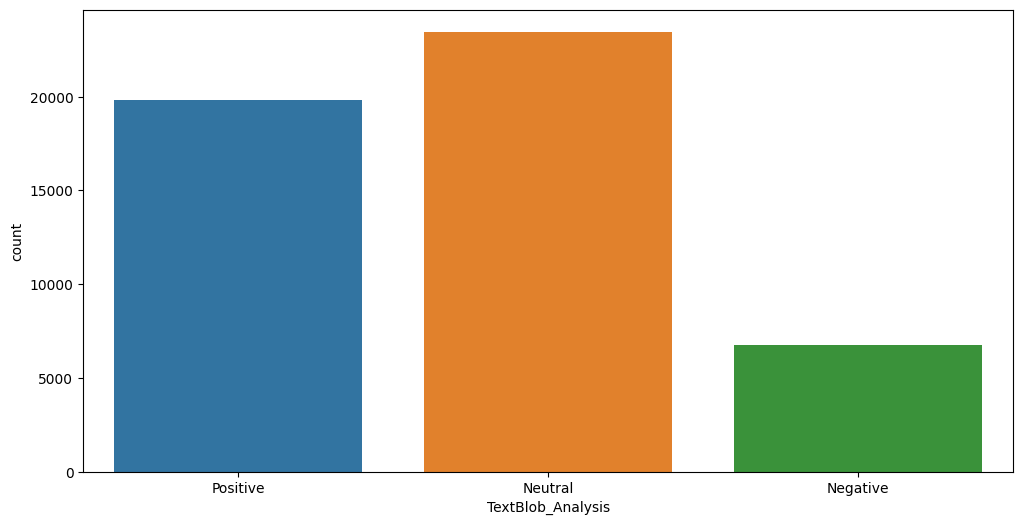

In [7]:
plt.figure(figsize=(12,6))
sns.countplot(x='TextBlob_Analysis',data=df)

In [8]:
fig = go.Figure(go.Funnelarea(
    text =temp.TextBlob_Analysis,
    values = temp.Tweet,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

In [9]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\s-\s', ' ', text)
    text = re.sub('\.{2,}', '', text)
    return text

In [10]:
df['Tweet'] = df['Tweet'].apply(lambda x:clean_text(x))
df['temp_list'] = df['Tweet'].apply(lambda x:str(x).split())
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]
df['temp_list'] = df['temp_list'].apply(lambda x:remove_stopword(x))

In [11]:
top = Counter([item for sublist in df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,oscars,8879
2,best,3172
3,tomorrow,2507
4,see,2228
5,like,2119
6,one,2051
7,win,1956
8,movie,1743
9,time,1724
10,good,1579


In [12]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [13]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

In [14]:
Positive_sent = df[df['TextBlob_Analysis']=='Positive']
Negative_sent = df[df['TextBlob_Analysis']=='Negative']
Neutral_sent = df[df['TextBlob_Analysis']=='Neutral']

In [15]:
#MosT common positive words
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,oscar,6802
1,oscars,4383
2,best,3121
3,win,1825
4,good,1511
5,movie,1221
6,see,1183
7,one,1181
8,tomorrow,1154
9,like,1113


In [16]:
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Positive Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [17]:
#MosT common negative words
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,oscars,1073
2,like,427
3,one,369
4,bad,357
5,see,339
6,time,306
7,tomorrow,293
8,people,274
9,dont,272
10,know,269


In [18]:
fig = px.treemap(temp_negative, path=['Common_words'], values='count',title='Tree Of Most Common Negative Words')
fig.show()

In [19]:
#MosT common Neutral words
top = Counter([item for sublist in Neutral_sent['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Blues')

,Common_words,count
1,oscars,3423
2,tomorrow,1060
3,see,706
4,like,579
5,one,501
6,watch,497
7,know,482
8,dont,445
9,time,419
10,awards,407


In [20]:
fig = px.bar(temp_neutral, x="count", y="Common_words", title='Most Commmon Neutral Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [21]:
fig = px.treemap(temp_neutral, path=['Common_words'], values='count',title='Tree Of Most Common Neutral Words')
fig.show()

In [22]:
df['temp_list1'] = df['Tweet'].apply(lambda x:str(x).split()) #List of words in every row for text
df['temp_list1'] = df['temp_list1'].apply(lambda x:remove_stopword(x)) #Removing Stopwords
raw_text = [word for word_list in df['temp_list1'] for word in word_list]

In [23]:
def words_unique(sentiment,numwords,raw_words):
    '''
    Input:
        segment - Segment category (ex. 'Neutral');
        numwords - how many specific words do you want to see in the final result; 
        raw_words - list  for item in train_data[train_data.segments == segments]['temp_list1']:
    Output: 
        dataframe giving information about the name of the specific ingredient and how many times it occurs in the chosen cuisine (in descending order based on their counts)..

    '''
    allother = []
    for item in df[df.TextBlob_Analysis != sentiment]['temp_list1']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))
    
    specificnonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in df[df.TextBlob_Analysis == sentiment]['temp_list1']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    
    return Unique_words

In [24]:
Unique_Positive= words_unique('Positive', 20, raw_text)
print("The top 20 unique words in Positive Tweets are:")
Unique_Positive.style.background_gradient(cmap='Greens')

The top 20 unique words in Positive Tweets are:


,words,count
0,excellent,136
1,greatest,84
2,iconic,57
3,latest,50
4,patchs,44
5,successful,40
6,fly,33
7,delicious,33
8,spectacular,33
9,beloved,32


In [25]:
fig = px.treemap(Unique_Positive, path=['words'], values='count',title='Tree Of Unique Positive Words')
fig.show()

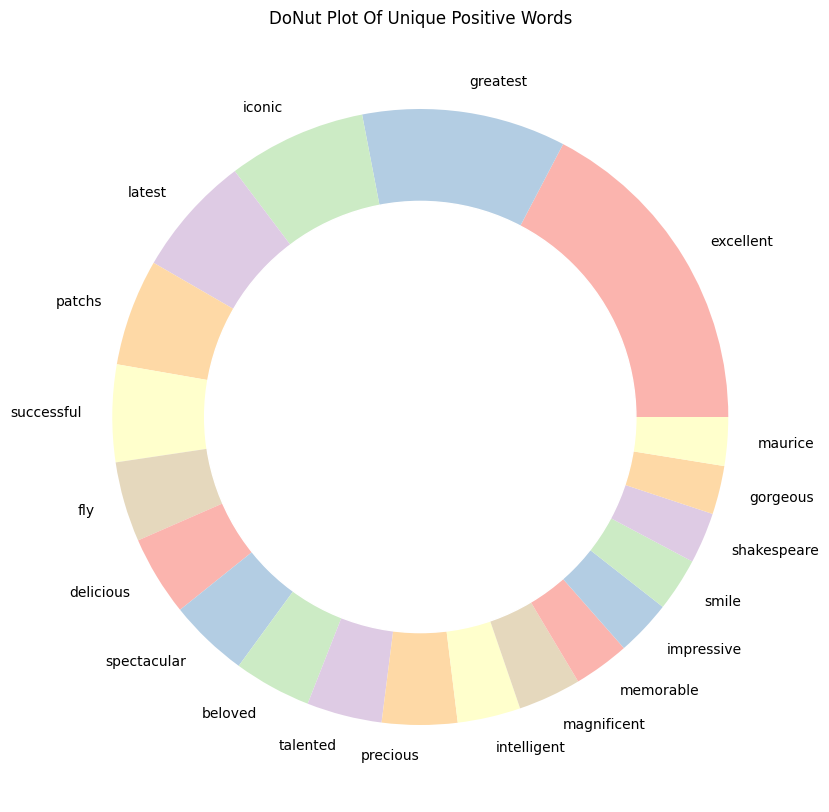

In [26]:
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Positive['count'], labels=Unique_Positive.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Positive Words')
plt.show()

In [27]:
Unique_Negative= words_unique('Negative', 10, raw_text)
print("The top 10 unique words in Negative Tweets are:")
Unique_Negative.style.background_gradient(cmap='Reds')

The top 10 unique words in Negative Tweets are:


,words,count
0,😁😆,42
1,stupidity,16
2,cruel,14
3,idiots,13
4,mere,13
5,ᦸ❨,13
6,badwesley,13
7,insulting,11
8,stockings,11
9,lame,10


C:\Users\17mar\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 6584 (\N{NEW TAI LUE VOWEL SIGN OA}) missing from current font.



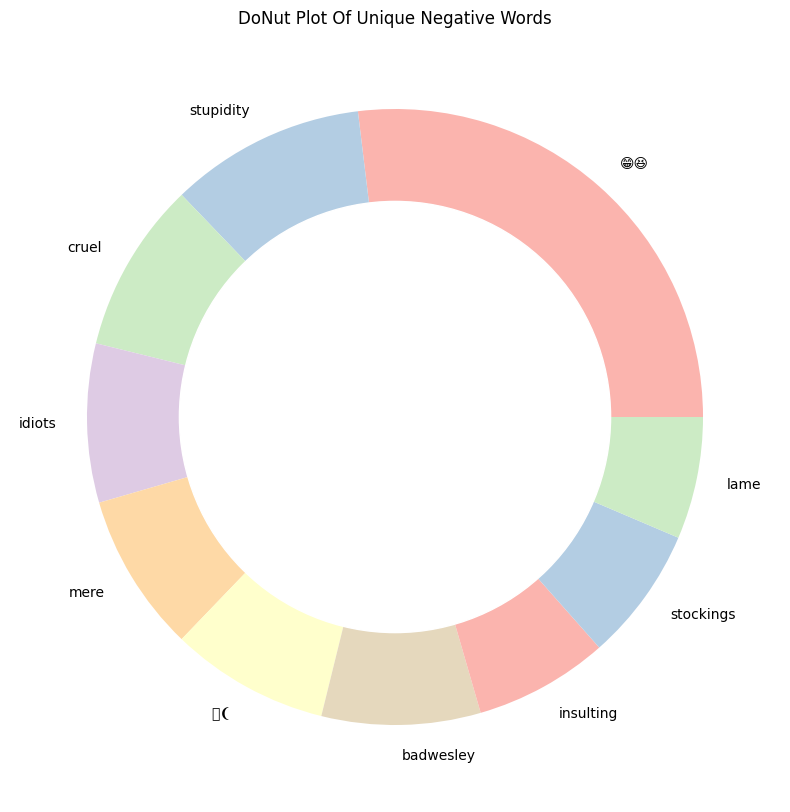

In [28]:
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.rcParams['text.color'] = 'black'
plt.pie(Unique_Negative['count'], labels=Unique_Negative.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Negative Words')
plt.show()

In [29]:
Unique_Neutral= words_unique('Neutral', 10, raw_text)
print("The top 10 unique words in Neutral Tweets are:")
Unique_Neutral.style.background_gradient(cmap='Oranges')

The top 10 unique words in Neutral Tweets are:


,words,count
0,ㅋㅋㅋ,52
1,💕😍,29
2,drblazquez,19
3,threatens,19
4,合,17
5,hefei,16
6,て,15
7,nuevofotodeperfil,14
8,shenzhen,14
9,＠,14


C:\Users\17mar\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 12619 (\N{HANGUL LETTER KHIEUKH}) missing from current font.

C:\Users\17mar\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 128149 (\N{TWO HEARTS}) missing from current font.

C:\Users\17mar\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from current font.

C:\Users\17mar\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 12390 (\N{HIRAGANA LETTER TE}) missing from current font.

C:\Users\17mar\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 65312 (\N{FULLWIDTH COMMERCIAL AT}) missing from current font.



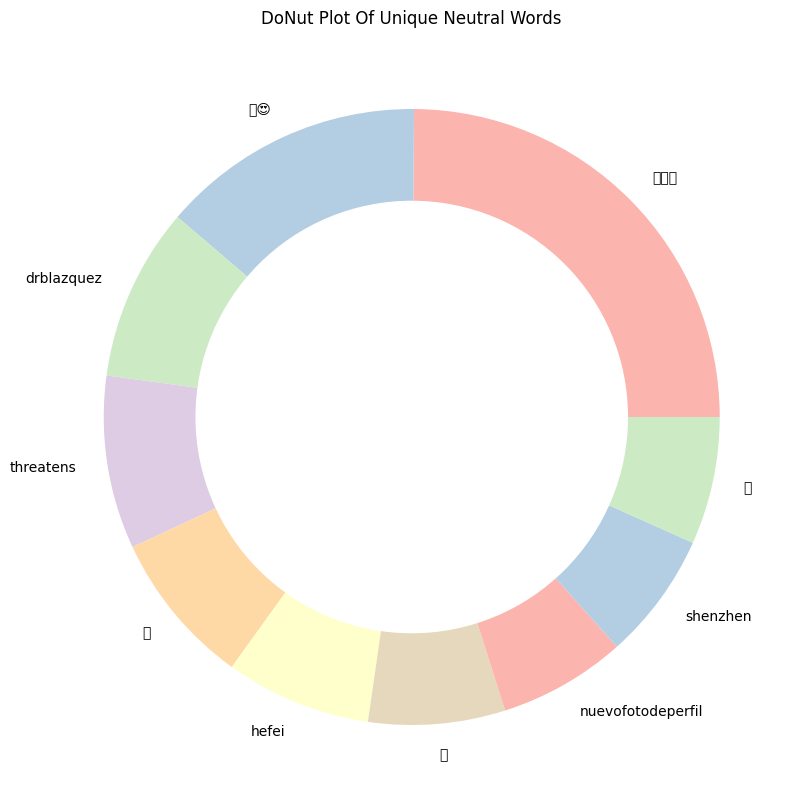

In [30]:
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Neutral['count'], labels=Unique_Neutral.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Neutral Words')
plt.show()

In [31]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

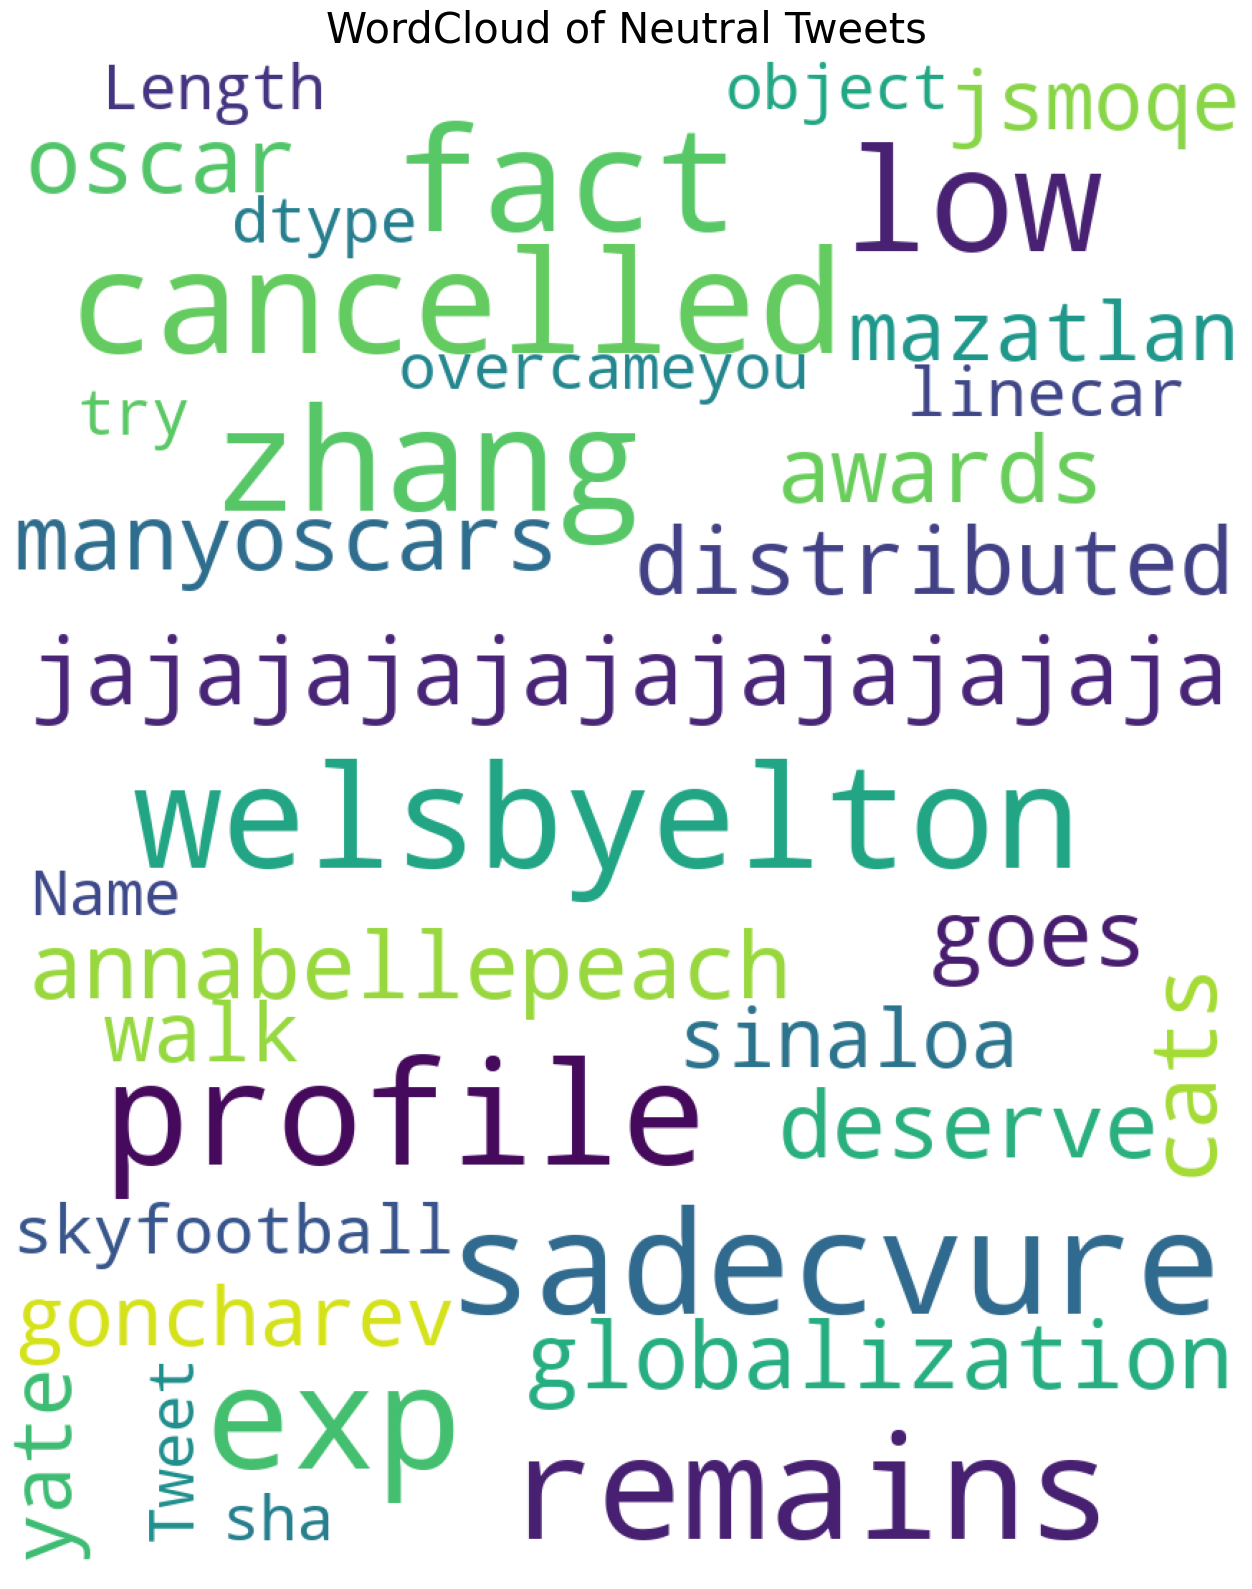

In [32]:
pos_mask = np.array(Image.open('statue.png'))
plot_wordcloud(Neutral_sent.Tweet,mask=pos_mask,color='white',max_font_size=100,title_size=30,title="WordCloud of Neutral Tweets")

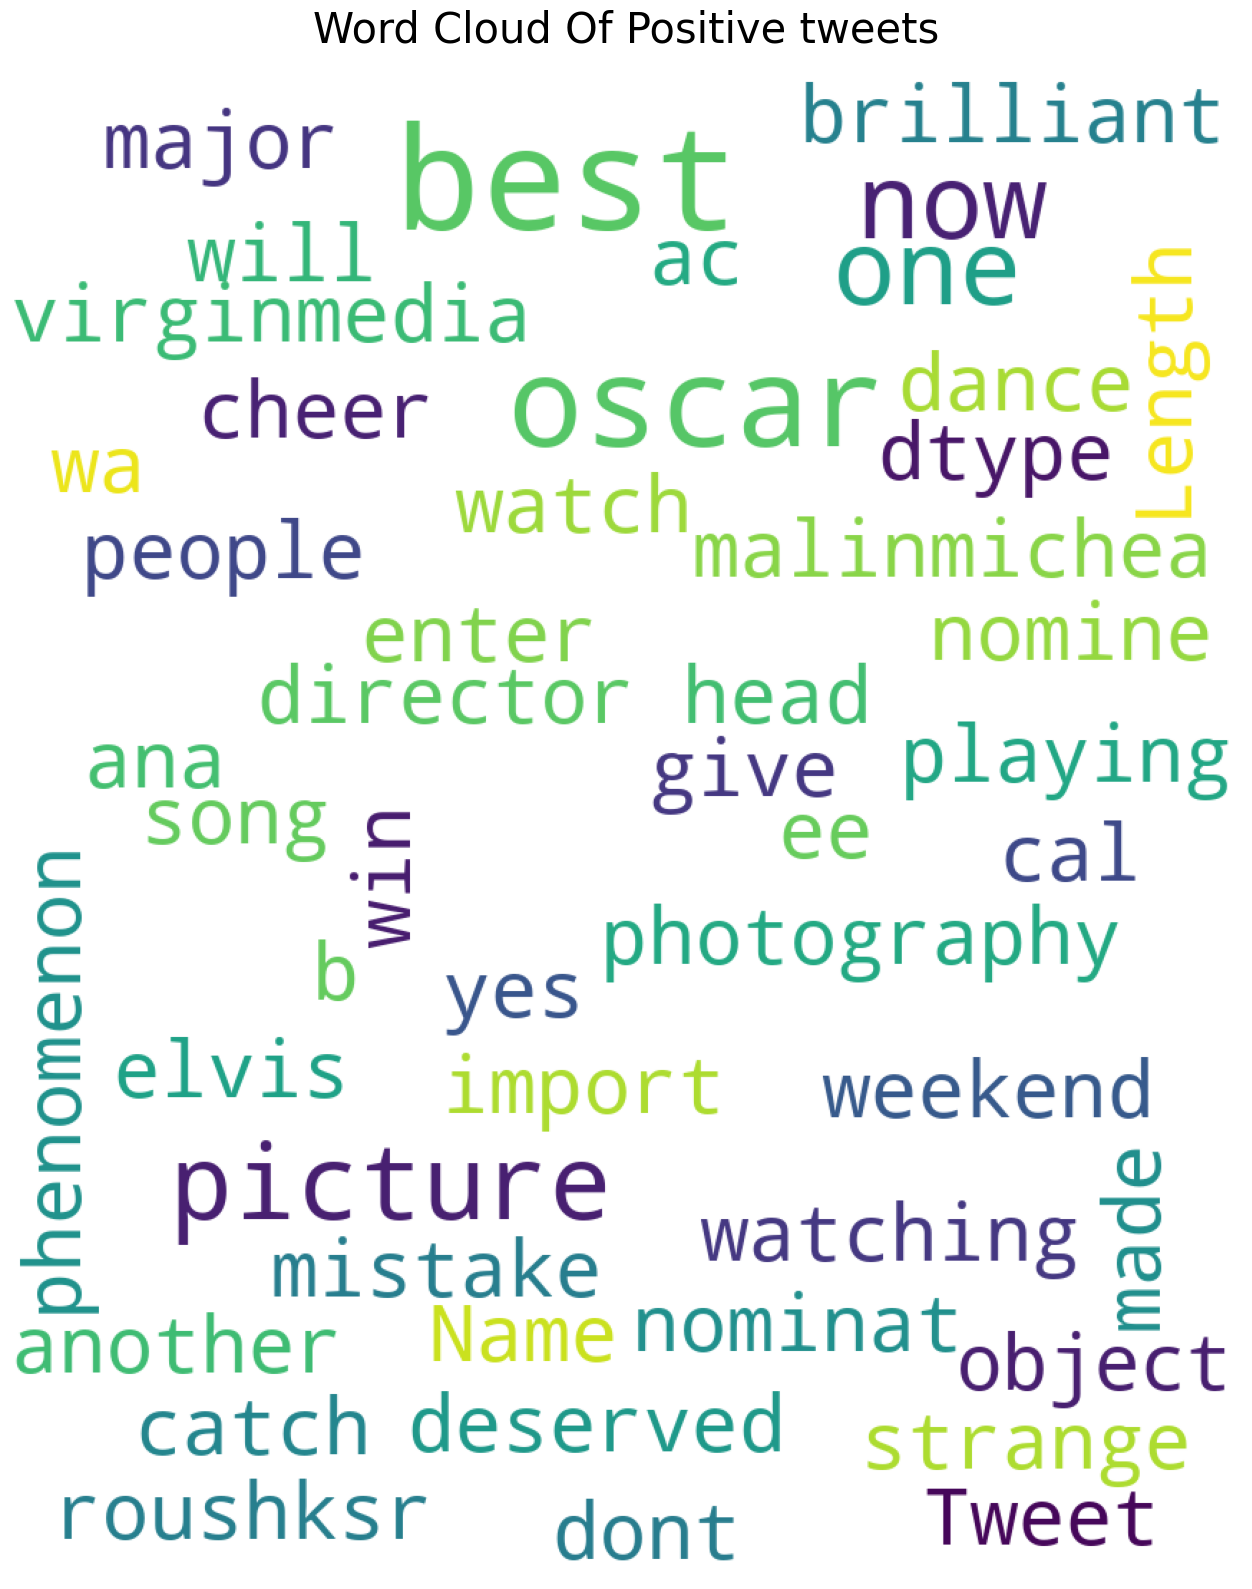

In [33]:
plot_wordcloud(Positive_sent.Tweet,mask=pos_mask,title="Word Cloud Of Positive tweets",title_size=30)


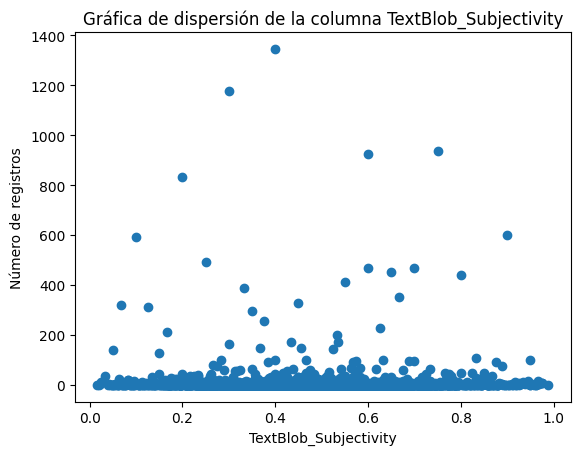

In [34]:
# Filtrar el dataframe para excluir los valores de 0 y 1
df_filtrado = df[(df['TextBlob_Subjectivity'] > 0) & (df['TextBlob_Subjectivity'] < 1) & (df['TextBlob_Subjectivity'] != 0.5)]

# Agrupar los datos filtrados y contar el número de registros en cada grupo
conteo_por_grupo = df_filtrado.groupby('TextBlob_Subjectivity').count()

# Crear una gráfica de dispersión
plt.scatter(conteo_por_grupo.index, conteo_por_grupo['TextBlob_Analysis'])

# Configurar los títulos y etiquetas de los ejes
plt.title('Gráfica de dispersión de la columna TextBlob_Subjectivity')
plt.xlabel('TextBlob_Subjectivity')
plt.ylabel('Número de registros')

# Mostrar la gráfica
plt.show()